# Задание

Набор данных ex3data1.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X (изменения уровня воды) и y (объем воды, вытекающий из дамбы). По переменной X необходимо предсказать y. Данные разделены на три выборки: обучающая выборка (X, y), по которой определяются параметры модели; валидационная выборка (Xval, yval), на которой настраивается коэффициент регуляризации; контрольная выборка (Xtest, ytest), на которой оценивается качество построенной модели.

Задание.
1. Загрузите данные ex3data1.mat из файла.
2. Постройте график, где по осям откладываются X и y из обучающей выборки.
3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.
4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.
5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта (2). Почему регуляризация в данном случае не сработает?
6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?
7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).
8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.
9. Обучите модель с коэффициентом регуляризации 0 и p = 8.
10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?
11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?
12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).
13. Вычислите ошибку (потерю) на контрольной выборке.

Ответы на вопросы представьте в виде отчета.

1. Загрузите данные ex3data1.mat из файла.

In [1]:
from scipy.io import loadmat
data = loadmat("Data/Lab 3/ex3data1.mat")

Xtrain, ytrain = data["X"], data["y"].flatten()
Xval, yval = data["Xval"], data["yval"].flatten()
Xtest, ytest = data["Xtest"], data["ytest"].flatten()

Xtrain.shape, ytrain.shape

((12, 1), (12,))

2. Постройте график, где по осям откладываются X и y из обучающей выборки.

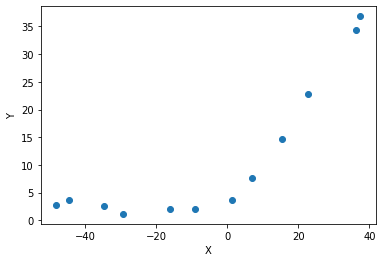

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(Xtrain, ytrain)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.  
4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.  

(Частично перееиспользуем код из лабораторных 1-2)

In [3]:
import numpy as np

class Loss(object):
    
    def __init__(self, model):
        self.model = model
    
    def __call__(self, x, y):
        raise NotImplementedError
    
    def grad(self, x, y):
        raise NotImplementedError


class LinearRegression(object):
    
    def __init__(self, dim):
        self.dim = dim + 1
        self.w = np.zeros(dim + 1)
    
    @property
    def weights(self):
        return self.w[:-1]
    
    @property
    def bias(self):
        return self.w[-1]
    
    def __repr__(self):
        return str(self.w)
    
    def __call__(self, x):
        value = np.dot(x, self.weights) + self.bias
        return float(value)
    
    def grad(self, x):
        return np.array(list(x) + [1])
    

class MSELoss(Loss):
    def __init__(self, model, reg_lambda):
        super().__init__(model)
        self.reg_lambda = reg_lambda

    def __call__(self, x, y):
        pred = np.array([self.model(x_i) for x_i in x])
        return np.mean((pred - y) ** 2) + self.reg_lambda * np.sum(self.model.weights ** 2)
    
    def grad(self, x, y):
        preds = np.array([self.model(x_i) for x_i in x])
        grads = np.array([self.model.grad(x_i) for x_i in x])
    
        errors = np.expand_dims(preds - y, axis=1)
        # No regularization for bias
        reg_term = 2. * self.reg_lambda * np.array(self.model.weights.tolist() + [0])

        return np.mean(2 * grads * errors, axis=0) + reg_term

In [4]:
model = LinearRegression(dim=1)
loss = MSELoss(model, reg_lambda=1.)

loss(Xtrain, ytrain), loss.grad(Xtrain, ytrain)

(281.90824176110783, array([-491.30399299,  -22.43517865]))

In [5]:
def get_gradient_descent(loss, alpha, eps, validation=None):
    def apply(X, y):
        iter_num = 0
        need_stop = False
        
        initial_loss = loss_before = loss_after = loss(X, y)

        loss_steps = {"train": [], "val": []}
        loss_steps["train"].append(loss(X, y))
        if validation is not None:
            X_val, y_val = validation
            loss_steps["val"].append(loss(X_val, y_val))
        
        while not need_stop:
            model_grad = loss.grad(X, y)  
            assert model_grad.shape == loss.model.w.shape
            
            loss.model.w -= alpha * model_grad
            loss_after = loss(X, y)
            assert loss_before >= loss_after
            
            need_stop = loss_before - loss_after <= eps
            
            loss_before = loss_after

            loss_steps["train"].append(loss(X, y))
            if validation is not None:
                X_val, y_val = validation
                loss_steps["val"].append(loss(X_val, y_val))
                
            iter_num += 1
        
        return {
            "initial_loss": initial_loss,
            "loss_after": loss_after,
            "loss_steps": loss_steps,
            "model": loss.model,
            "iter_num": iter_num
        }
    
    return apply

5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта (2). Почему регуляризация в данном случае не сработает?

In [6]:
model = LinearRegression(dim=1)
loss = MSELoss(model, reg_lambda=0.)

In [7]:
gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-6)
result = gradient_descent(Xtrain, ytrain)

trained_model = result["model"]

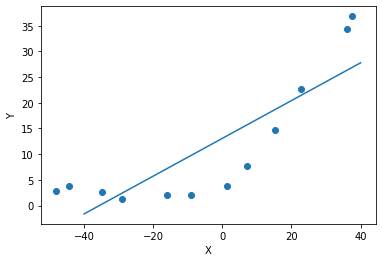

In [8]:
X_linspace = np.expand_dims(np.linspace(-40, 40, 100), axis=1)
y_linspace = np.array([trained_model(x_i) for x_i in X_linspace])

plt.scatter(Xtrain, ytrain)
plt.plot(X_linspace.flatten(), y_linspace)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Регуляризация тут не сработает потому что $\lambda$ = 0, те. слагаемое при L2-регуляризации зануляется в лоссе и градиенте

6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?

In [9]:
model = LinearRegression(dim=1)
loss = MSELoss(model, reg_lambda=0.)

In [10]:
gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-6, validation=(Xval, yval))
result = gradient_descent(Xtrain, ytrain)

train_curve = result["loss_steps"]["train"]
val_curve = result["loss_steps"]["val"]

assert len(train_curve) == len(val_curve)

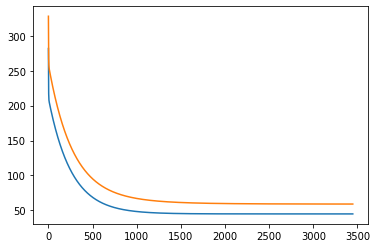

In [11]:
plt.plot(train_curve)
plt.plot(val_curve)
plt.show()

Значительного переобучения не наблюдается даже при $\lambda=0$ т.к. у модели сильный bias - мы аппроксимируем линейной функцию нелинейную зависимость (о чем свидетельствует достаточно большой train loss)

7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).

In [12]:
from sklearn.preprocessing import PolynomialFeatures

def add_polynomial_features(X, p):
    polynomial_transform = PolynomialFeatures(degree=p)
    return polynomial_transform.fit_transform(X)

8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

In [13]:
X_train_norm = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
assert X_train_norm.shape[0] == len(ytrain)

In [14]:
X_val_norm = (Xval - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
assert X_val_norm.shape[0] == len(yval)

In [15]:
X_test_norm = (Xtest - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
assert X_test_norm.shape[0] == len(yval)

9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [20]:
X_train_new = add_polynomial_features(X_train_norm, p=8)
X_val_new = add_polynomial_features(X_val_norm, p=8)

def train_model_with_regularization(train, val, reg_lambda):
    X_train, y_train = train
    model = LinearRegression(dim=X_train.shape[1])
    loss = MSELoss(model, reg_lambda)

    gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-3, validation=val)
    return gradient_descent(X_train, y_train)
    
result_0 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=0.)
result_0["model"]

[ 2.3979646   5.3533757   3.44534834  3.37967537  2.62010226  1.59080736
  1.42033116 -0.88809698 -0.88220668  2.3979646 ]

10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

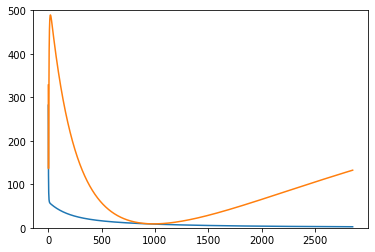

In [21]:
train_curve = result_0["loss_steps"]["train"]
validation_curve = result_0["loss_steps"]["val"]

plt.plot(train_curve)
plt.plot(validation_curve)
plt.ylim((0, 500))
plt.show()

Модель сошлась, лосс значительно ниже, чем был до лобавления полиномиальных фич. При этом на валидационной выборке показывает себя плохо - модель переобучена.

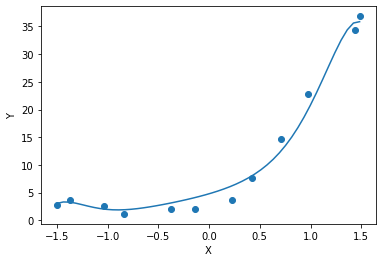

In [22]:
trained_model = result_0["model"]

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.scatter(X_train_norm, ytrain)
plt.plot(X_linspace.flatten(), y_linspace)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Модель почти идеально описывает данные из тренировочной выборки

11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?

In [23]:
result_1 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=1.)
result_100 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=100.)

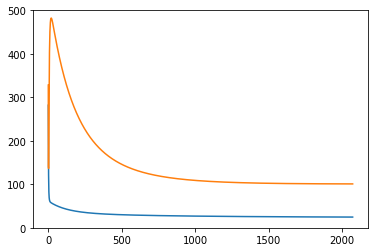

In [24]:
train_curve = result_1["loss_steps"]["train"]
validation_curve = result_1["loss_steps"]["val"]

plt.plot(train_curve)
plt.plot(validation_curve)
plt.ylim((0, 500))
plt.show()

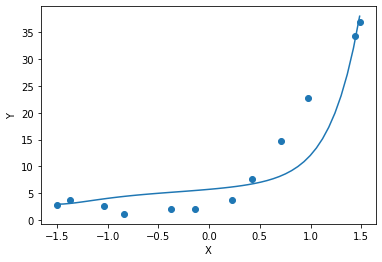

In [25]:
trained_model = result_1["model"]

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.scatter(X_train_norm, ytrain)
plt.plot(X_linspace.flatten(), y_linspace)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

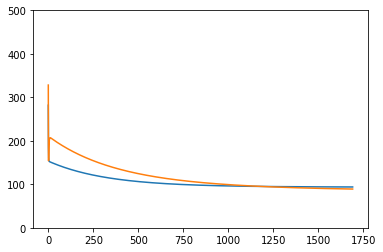

In [26]:
train_curve = result_100["loss_steps"]["train"]
validation_curve = result_100["loss_steps"]["val"]

plt.plot(train_curve)
plt.plot(validation_curve)
plt.ylim((0, 500))
plt.show()

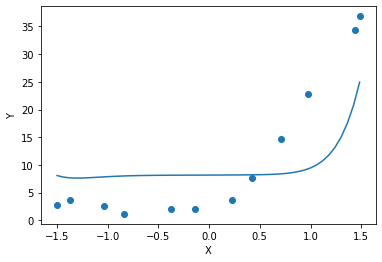

In [27]:
trained_model = result_100["model"]

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.scatter(X_train_norm, ytrain)
plt.plot(X_linspace.flatten(), y_linspace)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Видно, что регуляризация не дает модели переобучаться, однако излишняя регуляризация приводит к тому, что модель не может выучить зависимости исходных данных. Необходимо грамотно подобрать константу регуляризации, чтобы модель могла одновременно выучить зависимости из тренировочной выборки и генерализироваться на данные вне тренировочной выборки

12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

In [40]:
reg_lambda_range = np.arange(0., 5., 0.1)
val_loss_values = []

for reg_lambda in reg_lambda_range:
    result = train_model_with_regularization((X_train_new, ytrain), val=None, reg_lambda=reg_lambda)
    trained_model = result["model"]

    # Use MSELoss as a metric here, reg_lambda is not needed
    val_loss = MSELoss(trained_model, reg_lambda=0)
    val_loss_values.append(val_loss(X_val_new, yval))

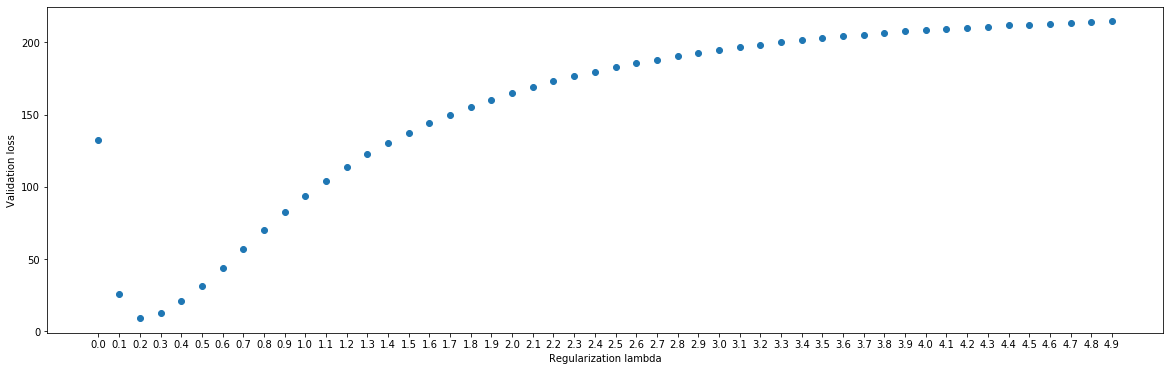

In [48]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(reg_lambda_range, val_loss_values)
plt.xticks(reg_lambda_range)
plt.xlabel("Regularization lambda")
plt.ylabel("Validation loss")
plt.show()

In [49]:
optimal_reg_lambda = reg_lambda_range[np.argmin(val_loss_values)]
optimal_reg_lambda

0.2

13. Вычислите ошибку (потерю) на контрольной выборке.

In [50]:
best_result = train_model_with_regularization((X_train_new, ytrain), val=None, reg_lambda=optimal_reg_lambda)
best_model = best_result["model"]

In [52]:
X_test_new = add_polynomial_features(X_test_norm, p=8)

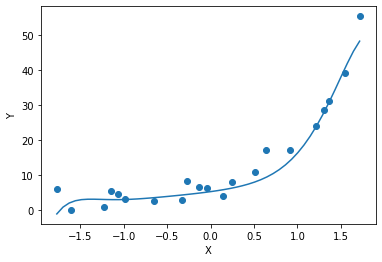

In [54]:
X_linspace = np.expand_dims(np.linspace(np.min(X_test_norm), np.max(X_test_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([best_model(x_i) for x_i in X_linspace_new])

plt.scatter(X_test_norm, ytest)
plt.plot(X_linspace.flatten(), y_linspace)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [55]:
test_loss = MSELoss(best_model, reg_lambda=0)
test_loss(X_test_new, ytest)

10.660894037084287